# 1. Imports

In [2]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.3 MB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 50.3 MB/s 
     |████████████████████████████████| 34.5 MB 14 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [4]:
from art import *

from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

from matplotlib import pyplot as plt

import numpy as np
from math import pi

import seaborn as sn
import pandas as pd

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import mean_squared_error as MSE

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from random import random, randint

# 2. Draw the confusion matrix

In [5]:
def confusion_matrix(pred0, pred1, n_classes=5):
    """ Creates the n_classes*n_classes confusion matrix of pred1 compared to the original pred0. 
        - cmat[i,j] = nb of pts classified as i at the origin and as j after the attack """
    cmat = np.zeros((n_classes,n_classes)).astype(int)
    n_sample = pred0.shape[0]
    for k in range(n_sample):
        cmat[pred0[k],pred1[k]] += 1
    return(cmat)

In [7]:
def norm_rows(cmat):
    """ Normalizes the lines of the confusion matrix cmat. """
    n = cmat.shape[0]
    ncmat = np.zeros((n,n))
    sum_rows = np.sum(cmat, axis=1)
    for k in range(n):
        s = sum_rows[k]
        if s != 0:
            ncmat[k,:] = cmat[k,:]/sum_rows[k]
    return(ncmat)

In [8]:
def attack(method, classifier):
    """TO COMPLETE WITH YOUR ATTACKS"""

    if method=="nf":
        return NewtonFool(classifier=classifier, 
                          eta=0.95, 
                          max_iter = 20,
                          verbose=True)
    return NewtonFool(classifier=classifier, 
                      eta=0.95, 
                      max_iter = 20,
                      verbose=True)

In [9]:
def build_confusion_matrix(N, method="nf", num_network=(1, 1), folder="/content/"):
    """Do not forget to set folder and, if you use Colab, to import your neural networks!"""
    # Load the model
    path_model = folder + "ACASXU_{}_{}.h5".format(num_network[0], num_network[1])
    model = load_model(path_model)
    model.compile()

    # ACAS classifier

    ACAS_classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=MSE,
    train_step=None,
    nb_classes=5,
    input_shape=(1, 5),
    clip_values=(-1.0, 1.0),
    )

    att = attack(method, ACAS_classifier)

    # Apply the attack

    original_pts = np.random.rand(N, 5)
    adv_pts = att.generate(original_pts)
    original_pred = model.predict(original_pts)
    adv_pred = model.predict(adv_pts)
    original_advice = np.argmin(original_pred, axis=1)
    adv_advice = np.argmin(adv_pred, axis=1)

    # confusion matrix
    cmat = confusion_matrix(original_advice, adv_advice)

    # confusion matrix with normalized lines
    ncmat_nf = norm_rows(cmat)

    index0 = ["COC (" + str(original_advice[original_advice==0].size) + ")",
              "WR (" + str(original_advice[original_advice==1].size) + ")",
              "WL (" + str(original_advice[original_advice==2].size) + ")",
              "SR (" + str(original_advice[original_advice==3].size) + ")",
              "SL (" + str(original_advice[original_advice==4].size) + ")"]
    index1 = ["adv-COC (" + str(adv_advice[adv_advice==0].size) + ")",
              "adv-WR (" + str(adv_advice[adv_advice==1].size) + ")",
              "adv-WL (" + str(adv_advice[adv_advice==2].size) + ")",
              "adv-SR (" + str(adv_advice[adv_advice==3].size) + ")",
              "artSL (" + str(adv_advice[adv_advice==4].size) + ")"]

    df_cmat = pd.DataFrame(ncmat_nf, index = index0, columns = index1)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmat, annot=True)
    plt.title("Confusion matrix - " + method.upper() + " - #{0}".format(N) + " - network {}_{}".format(num_network[0], num_network[1]))
    plt.show()

NewtonFool:   0%|          | 0/50 [00:00<?, ?it/s]

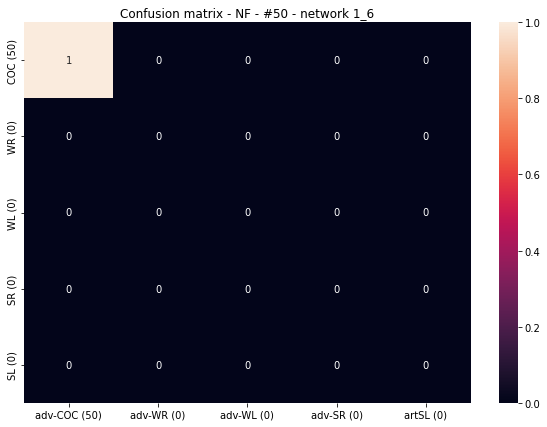

In [10]:
build_confusion_matrix(50, "nf", (1, 6))